# Logistic regression model with CV and lasso regularisation 

**Questions :**
- What number of iterations to ensure convergence ?
- What lasso regularisation parameter ?
- What cross-validation method ?
- Validation/in/out sample sizes


**ISSUES :**
- missing values in the eeg : drop or try to replace ?
- convergence of the model

**Notes :**
- no significant class imbalance 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

## Preamble

In [3]:
from source.preamble import *

train_eeg_names = os.listdir(Dir.eeg_train)
train_spc_names = os.listdir(Dir.spc_train)
len(train_eeg_names), len(train_spc_names)

(17300, 11138)

## Functions definition

In [4]:
from source.classes import Eeg, ChainBuilder, EegChain, FeatureGenerator
from source.scoring import compute_wasserstein, score
from source.train_algos import (
    train_logistic_regression_CV,
    test_model,
    predict_probas_test_set,
)
from source.process import open_train_metadata, print_summary_metadata
from source.pre_train import extract_validation_set
from source.plotting import plot_coefs, plot_distributions

## Process metadata

In [5]:
meta_all = open_train_metadata(read=False)
print_summary_metadata(meta_all)
meta_all.iloc[:10]

Metadata summary :
Len :  106800


,n_sample,percent
expert_consensus,,
GPD,16702,15
GRDA,18861,17
LPD,14856,13
LRDA,16640,15
Other,18808,17
Seizure,20933,19


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,n_votes,eeg_length
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
5,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
6,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
7,1628180742,7,36.0,353733,7,36.0,3811483573,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
8,1628180742,8,40.0,353733,8,40.0,3388718494,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0.0,0.0,0.454545,0.0,0.090909,0.454545,11,50


## Sample class usage
For Eeg class :

EEG sub id :  1


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-80.519997,-70.540001,-80.110001,-108.750000,-120.330002,-88.620003,-101.750000,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.920000
1,-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.820000,-104.260002,-99.730003,-99.070000,-92.290001,-96.019997,-84.500000,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.500000,-102.059998,29.219999
2,-80.209999,-75.870003,-82.050003,-106.010002,-117.500000,-87.489998,-99.589996,-96.820000,-119.680000,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
3,-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.750000,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.180000,-128.940002,-109.889999,83.870003
4,-90.570000,-80.790001,-93.000000,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.930000,-115.639999,-99.800003,-97.500000,-88.730003,-114.849998,-100.250000,97.769997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,-144.660004,-147.809998,-129.820007,-129.460007,-157.509995,-124.000000,-124.570000,-94.820000,-153.070007,-121.110001,-86.459999,-132.520004,-138.339996,-128.970001,-71.300003,-114.480003,-86.709999,-114.959999,-81.500000,-20.070000
17996,-140.880005,-153.000000,-129.529999,-129.020004,-154.059998,-131.220001,-128.380005,-95.000000,-140.820007,-114.639999,-84.379997,-115.339996,-119.230003,-114.709999,-70.989998,-92.129997,-79.639999,-116.139999,-81.879997,10.600000
17997,-133.729996,-141.770004,-121.900002,-122.370003,-158.750000,-123.550003,-127.730003,-93.089996,-125.230003,-106.489998,-83.419998,-112.720001,-103.209999,-107.629997,-61.869999,-97.910004,-77.150002,-106.500000,-75.339996,-2.060000
17998,-141.449997,-151.139999,-127.190002,-128.699997,-163.460007,-124.309998,-129.479996,-94.419998,-140.869995,-113.339996,-83.519997,-129.300003,-118.650002,-117.589996,-71.879997,-99.279999,-83.900002,-116.160004,-81.410004,2.820000


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
1200,-129.460007,-115.580002,-115.129997,-157.440002,-166.979996,-126.260002,-133.429993,-124.349998,-116.629997,-112.110001,-117.040001,-103.169998,-100.070000,-133.970001,-103.449997,-100.059998,-90.040001,-132.460007,-107.230003,-5.900000
1201,-128.740005,-112.330002,-112.059998,-154.830002,-164.440002,-121.230003,-135.380005,-122.269997,-114.930000,-107.370003,-111.059998,-100.480003,-96.330002,-122.019997,-95.400002,-98.309998,-83.660004,-122.070000,-97.180000,9.670000
1202,-128.600006,-112.550003,-107.489998,-148.360001,-154.089996,-114.110001,-129.470001,-115.989998,-123.620003,-104.839996,-100.190002,-104.250000,-106.040001,-116.940002,-96.059998,-96.620003,-91.120003,-127.430000,-93.900002,-3.030000
1203,-123.449997,-106.440002,-108.870003,-148.309998,-158.080002,-118.129997,-133.350006,-117.790001,-106.150002,-95.480003,-97.440002,-93.980003,-90.500000,-109.900002,-86.510002,-93.559998,-86.019997,-121.650002,-92.110001,33.880001
1204,-129.770004,-119.430000,-111.879997,-148.029999,-145.830002,-118.040001,-140.699997,-113.980003,-97.209999,-85.459999,-91.620003,-83.529999,-71.750000,-96.820000,-71.599998,-85.779999,-68.370003,-105.889999,-85.059998,65.309998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11195,-156.139999,-149.660004,-115.019997,-130.360001,-167.929993,-94.500000,-117.029999,-130.899994,-137.979996,-129.869995,-122.279999,-127.019997,-133.919998,-183.699997,-83.559998,-112.889999,-124.989998,-150.190002,-126.360001,100.959999
11196,-168.899994,-157.619995,-168.679993,-141.410004,-199.839996,-118.550003,-114.269997,-132.399994,-169.940002,-158.889999,-131.960007,-159.110001,-186.610001,-278.440002,-106.930000,-113.339996,-1.440000,-167.160004,-134.429993,120.190002
11197,-164.080002,-143.070007,-211.740005,-165.570007,-201.369995,-90.730003,-120.489998,-134.940002,-170.300003,-168.910004,-143.000000,-159.619995,-211.259995,-271.290009,-116.010002,-68.989998,-131.259995,-179.529999,-141.350006,148.399994
11198,-168.080002,-148.940002,-118.269997,-145.429993,-162.889999,-128.440002,-120.709999,-123.620003,-124.800003,-108.779999,-117.269997,-135.500000,-126.430000,-23.309999,-87.169998,-90.980003,-148.750000,-162.380005,-129.490005,123.660004


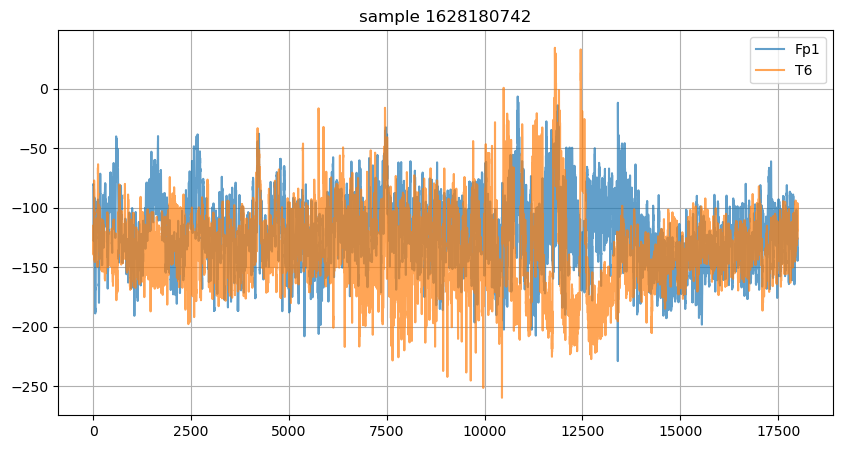

In [6]:
eeg = Eeg(Dir.eeg_train, meta_all.iloc[1])
print("EEG sub id : ", eeg.eeg_sub_id)
display(eeg.open())  # the whole EEG
display(eeg.open_subs())  # only the selected subsample
eeg.plot(columns=["Fp1", "T6"])

For FeatureGenerator and EegChain : 
- cascading methods
- reusable object

In [7]:
def eeg_chain_train(sample):
    return (
        EegChain()
        .open(Eeg(Dir.eeg_train, sample))
        ._fillna()
        ._divide(coef=1000.0)
        .mean(cols=["Fp1", "EKG"])
        .var(cols=["EKG"])
        .signature(
            cols=["Fp1", "EKG", "F7", "T3", "O2"],
            depth=3,
            index=[i for i in range(ChainBuilder.n_sig_coordinates(5, 3))],
            time_augment=True,
        )
        .result()
    )


feature_generator = FeatureGenerator(eeg_chain=eeg_chain_train)

meta_sample = meta_all.iloc[:100]

features = feature_generator.process(metadata=meta_sample, save=False)
features

Fp1-mean  EKG-mean   EKG-var  sig-()  sig-(2)  sig-(3)  \
eeg_id     eeg_sub_id                                                           
1628180742 0          -0.117237  0.016077  0.050067     1.0 -0.05082  0.01763   
           1          -0.117181  0.015293  0.050846     1.0 -0.03695  0.10807   
           2          -0.118178  0.014988  0.050578     1.0 -0.03949  0.17994   
           3          -0.115651  0.014743  0.050227     1.0  0.04395 -0.12296   
           4          -0.117538  0.011713  0.049154     1.0 -0.03094  0.05833   
...                         ...       ...       ...     ...      ...      ...   
893864755  5          -0.010563  0.004429  0.003238     1.0 -0.05735  0.00865   
3669581453 0          -0.116418  0.014463  0.010591     1.0  0.64488  0.37912   
           1          -0.078232  0.034246  0.007329     1.0  0.35331  0.21264   
           2          -0.065501  0.040890  0.006563     1.0  0.24823  0.05442   
1424484930 0          -0.012822  0.007750  0.000015     1.0  0.04923  0.00315   

                       sig-(4)  sig-(5)  sig-(1,1)  sig-(1,3)  ...  \
eeg_id     eeg_sub_id                                          ...   
1628180742 0          -0.00284  0.00596   -0.00789  -0.705080  ...   
           1          -0.04524  0.01525   -0.02633  -2.461585  ...   
           2          -0.09799 -0.03118   -0.04057   0.012505  ...   
           3           0.03698  0.05744   -0.04503   1.054060  ...   
           4          -0.07580 -0.07144    0.05585  -0.688098  ...   
...                        ...      ...        ...        ...  ...   
893864755  5          -0.10351 -0.11353    0.00671  -1.285850  ...   
3669581453 0           0.66667  0.57474    0.58813   5.064291  ...   
           1           0.38021  0.39810    0.33571  -1.758953  ...   
           2           0.21273  0.25664    0.24803   1.052545  ...   
1424484930 0           0.04298  0.02610   -0.05357   2.289225  ...   

                       sig-(5,4,1)  sig-(5,4,2)  sig-(5,4,3)  sig-(5,4,4)  \
eeg_id     eeg_sub_id                                                       
1628180742 0              0.001605    -0.420259    -0.013248    -0.020081   
           1              0.006697    -0.250066     0.014523    -0.004452   
           2             -0.009504    -0.204089     0.000607     0.003456   
           3             -0.013772    -0.158892    -0.006716    -0.006023   
           4             -0.000863    -0.233044     0.000907     0.009662   
...                            ...          ...          ...          ...   
893864755  5             -0.001775    -0.035095    -0.003135    -0.003925   
3669581453 0              0.075353     0.035002     0.071086     0.117269   
           1              0.093516    -0.121868     0.074988     0.047529   
           2              0.027423    -0.090115     0.028729     0.026352   
1424484930 0              0.002720     0.000134     0.002563     0.001348   

                       sig-(5,4,5)  sig-(5,5,1)  sig-(5,5,2)  sig-(5,5,3)  \
eeg_id     eeg_sub_id                                                       
1628180742 0              0.007114   -25.597951    -0.017579    -0.013861   
           1              0.012574    30.707450    -0.092523     0.101229   
           2              0.010839   -76.866306    -0.033504    -0.538101   
           3              0.001614    37.642230     0.003809    -0.261191   
           4             -0.014157   -65.023187     0.004140    -0.192819   
...                            ...          ...          ...          ...   
893864755  5             -0.000275   -66.011290     0.020390    -0.020673   
3669581453 0             -0.001608   100.000000     1.539104     1.489982   
           1              0.010278   100.000000    -1.035881     1.184502   
           2             -0.004102   100.000000     0.039669    -0.298892   
1424484930 0             -0.000920    -0.118194    -0.019437     0.000263   

                       sig-(5,5,4)  sig-(5,5,5)  
eeg_

## Train
- make sure not to generate class imbalance
- seed should be fixed in local for debug

In [8]:
# split validation
rest_meta, validation_meta = extract_validation_set(meta_all, ratio=0.02)
print_summary_metadata(rest_meta)
print_summary_metadata(validation_meta)

Metadata summary :
Len :  104664


,n_sample,percent
expert_consensus,,
GPD,16366,15
GRDA,18512,17
LPD,14553,13
LRDA,16305,15
Other,18417,17
Seizure,20511,19


Metadata summary :
Len :  2136


,n_sample,percent
expert_consensus,,
GPD,336,15
GRDA,349,16
LPD,303,14
LRDA,335,15
Other,391,18
Seizure,422,19


In [11]:
# parameters
max_nsample = 100 if KAGGLE else 100
max_it = 1200
cs = 0.08


def eeg_chain_train(sample):
    return (
        EegChain()
        .open(Eeg(Dir.eeg_train, sample))
        ._fillna()
        ._divide(coef=1000.0)
        .mean(cols=["Fp1", "EKG"])
        .var(cols=["EKG"])
        .signature(
            cols=["Fp1", "EKG", "F7", "T3", "O2"],
            depth=3,
            index=[i for i in range(ChainBuilder.n_sig_coordinates(5, 3))],
            time_augment=True,
        )
        .result()
    )


feature_generator = FeatureGenerator(
    eeg_chain=eeg_chain_train,
    save=os.path.join(Dir.intermediate_output, "eeg_features_train.parquet"),
)

model, *other = train_logistic_regression_CV(
    rest_meta,
    feature_generator,
    VOTE_COLS,
    max_it=max_it,
    max_nsample=max_nsample,
    grade=Grade.certain,
    scale=True,
    Cs=[cs],
    fit_intercept=False,
)

c:\miniconda3\envs\hms\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
# keep the same preprocessing for the test and validation data
scaler = other[0]

(<Figure size 600x1200 with 4 Axes>,
 array([<Axes: title={'center': 'Coefficient values'}>,
        <Axes: title={'center': 'Lasso unselected coefs (268 out of 936 remaining)'}>],
       dtype=object))

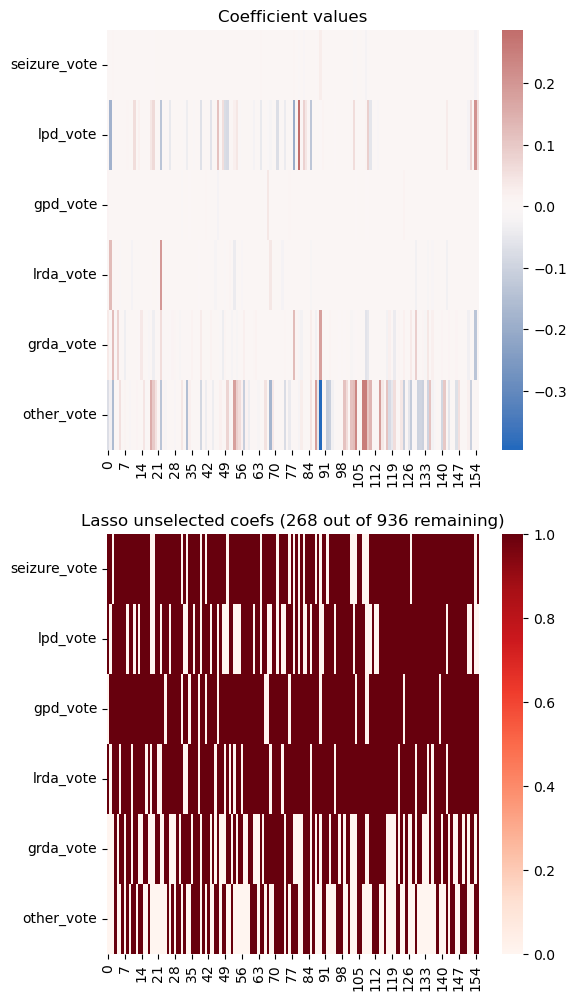

In [39]:
plot_coefs(model)

### Tune lasso regularisation parameter

In [ ]:
if not KAGGLE:
    target_probas = validation_meta[VOTE_COLS]

	Cs= 0.1
Number of samples without missing values selected :  809
(809, 40) (809,)


c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Number of samples without missing values selected :  8948
Wasserstein metric : 1.385537083857391


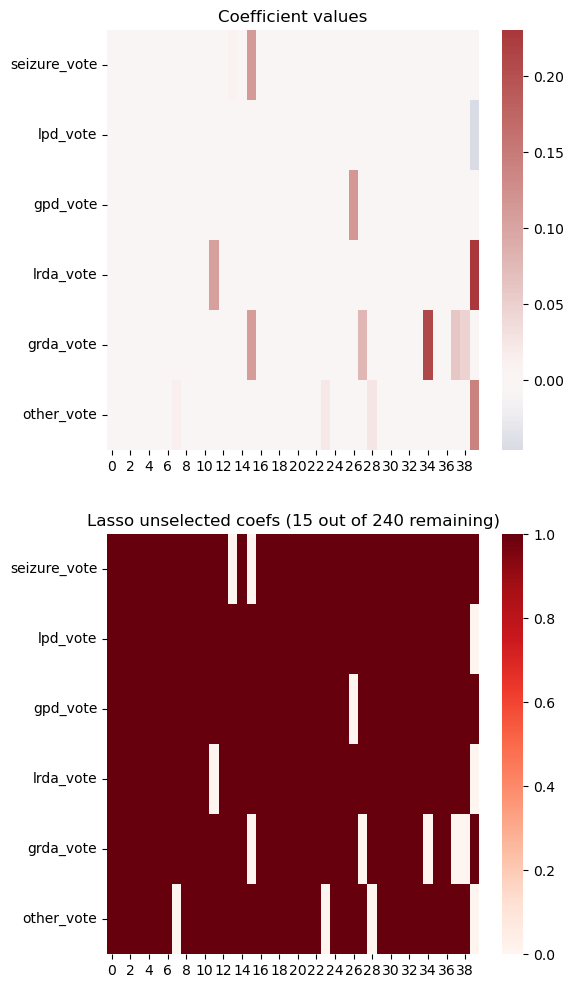

	Cs= 1.0
Number of samples without missing values selected :  809
(809, 40) (809,)


c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached 

Number of samples without missing values selected :  8948
Wasserstein metric : 1.323104775689118


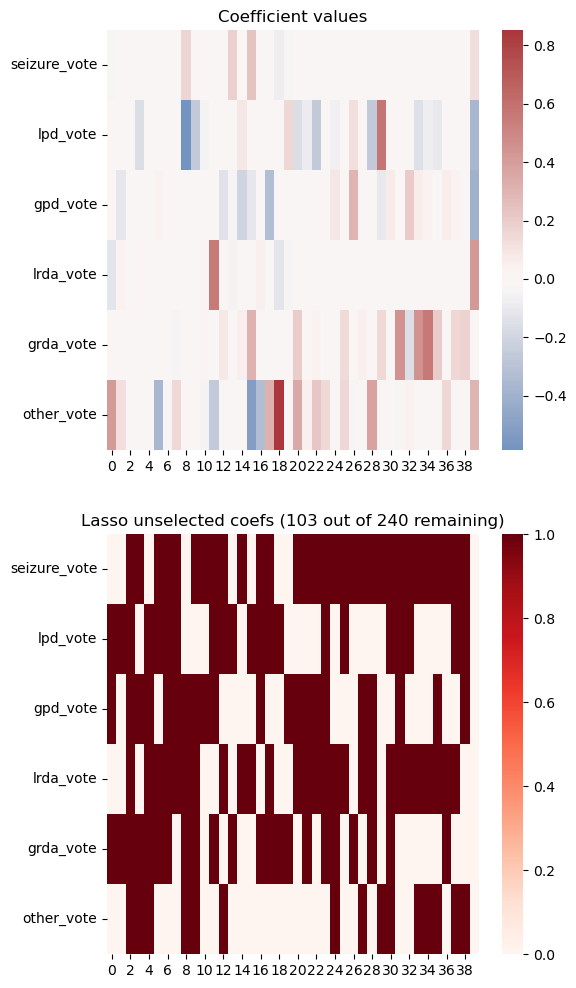

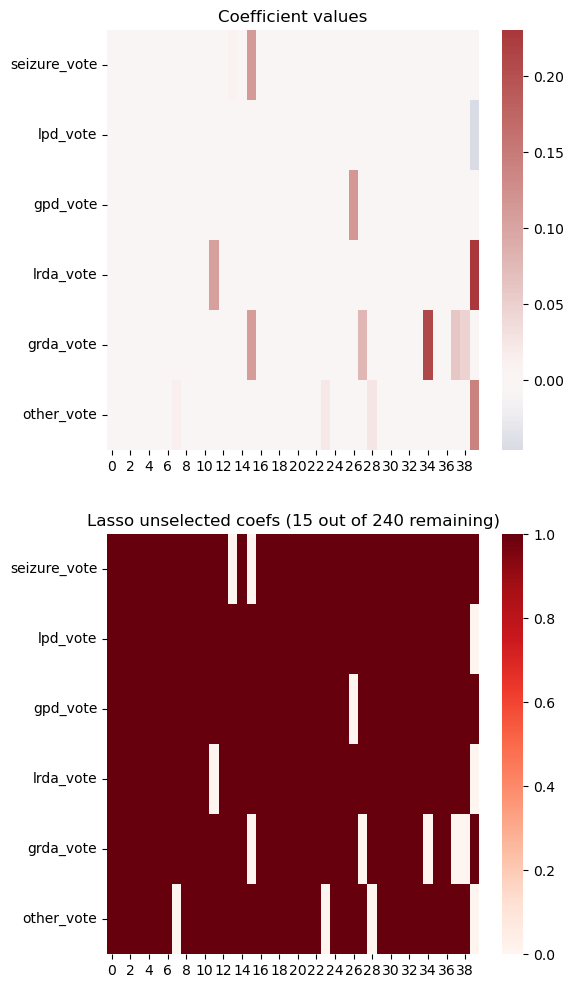

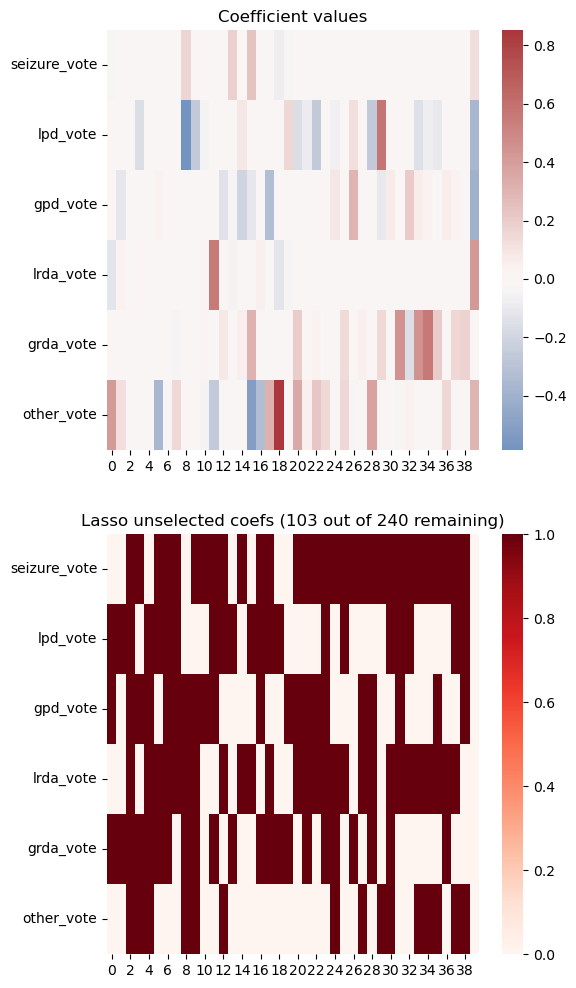

In [ ]:
max_nsample = 1000 if KAGGLE else 1000
max_it = 1000
csx = np.linspace(0.1, 1, 2, endpoint=True)
for cs in csx:
    print("=" * 50)
    print("\tCs=", cs)
    model, *other = train_logistic_regression_CV(
        rest_meta,
        VOTE_COLS,
        max_it=max_it,
        max_nsample=max_nsample,
        grade=Grade.certain,
        scale=True,
        Cs=[cs],
    )
    scaler = other[0]
    predicted_probas = test_model(model, VOTE_COLS, validation_meta, scaler)
    print("Wasserstein metric :", compute_wasserstein(predicted_probas, target_probas))
    fig, _ = plot_coefs(model)
    display(fig)

- Tune lasso regularisation parameter :
    - with Logistic regression **10 fold CV** and **Z-score scaling** 
    - 1000 train samples
    - max solver iteration = 1000 (saga)
    - **CONVERGENCE ISSUES** (max iteration reached)
    - *TAKEAWAY* :
        - min generalisation error between 1. and 3.
        - Cs = .1 selects only few features per class
        - Var(EKG) always selected


In [70]:
target_probas

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
12800,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
43918,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
26217,0.470588,0.411765,0.117647,0.000000,0.0,0.000000
27450,0.000000,0.000000,0.000000,0.000000,0.5,0.500000
40535,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
...,...,...,...,...,...,...
31991,0.000000,0.000000,0.000000,0.461538,0.0,0.538462
23323,0.000000,0.000000,0.000000,0.000000,0.2,0.800000
100394,0.000000,0.133333,0.000000,0.866667,0.0,0.000000
71001,1.000000,0.000000,0.000000,0.000000,0.0,0.000000


## Test
Not yet defined how to deal with NA values in the signals 
=> they are skipped for now

Also need to fix the computation of the subsample length (at each change of file)
=> those are skipped as well

"clean" => keep only data that has no issue
In the future should not drop any test values

In [41]:
# in case we want to get rid of outliars ?
validation_meta_clean = validation_meta

In [42]:
if not KAGGLE:
    feature_generator = FeatureGenerator(
        eeg_chain=eeg_chain_train,
        save=os.path.join(Dir.intermediate_output, "eeg_features_test.parquet"),
    )
    predicted_probas = test_model(
        model, feature_generator, VOTE_COLS, validation_meta_clean, scaler
    )

In [43]:
# UNIFORM PREDICTED PROBAS
# most basic benchmark
pp = [1.0 / 6] * 6
predicted_probas_uniform = np.array([pp for _ in range(len(validation_meta_clean))])

**Note** : 
for nsample < 30000 and maxit < 2000, the uniform benchmark is not even outperformed

(with the very simple set of features)

Classes not linearly separable, even with terms of the signature.

In [44]:
if not KAGGLE:
    target_probas = validation_meta_clean[VOTE_COLS]

In [45]:
score(predicted_probas_uniform, target_probas.values)

,MSE,Wasserstein,KullbackLDiv
0,0.002775,1.429081,0.23276


In [46]:
score(predicted_probas, target_probas.values)

,MSE,Wasserstein,KullbackLDiv
0,0.002794,1.390971,0.280361


> confusion matrix to visualise which classes are better classified

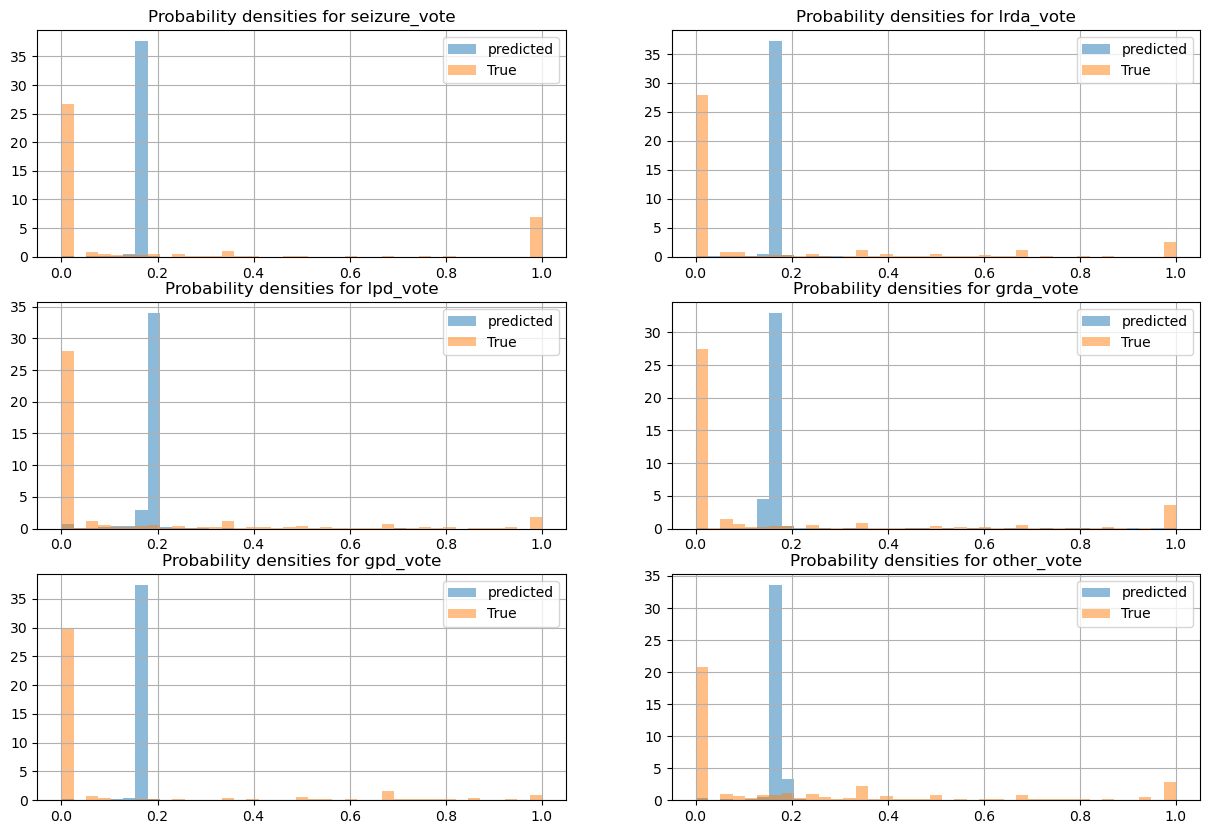

In [77]:
plot_distributions(predicted_probas, target_probas.values)

> The linear regression sucks : it didn't budge from uniform distribution

## Conclusion

- Regularisation is usefull in our case as many features are redundant and many of them don't have predictive power.
- It it still very inefficient : it is very similar to the uniform predictor

This indicates that even in the time-augmented feature-space, the classes are not linearly independant.

It could be interesting not to perform the time-augmentation so that the scaling of patterns would be matched.

## Submission

In [47]:
# the true test samples
meta_test = pd.read_csv(os.path.join(Dir.root, "test.csv"))

In [55]:
# recreate the objects for the submission folder
def eeg_chain_test(sample):
    return (
        EegChain()
        .open(Eeg(Dir.eeg_test, sample))
        ._fillna()
        ._divide(coef=1000.0)
        .mean(cols=["Fp1", "EKG"])
        .var(cols=["EKG"])
        .signature(
            cols=["Fp1", "EKG", "F7", "T3", "O2"],
            depth=3,
            index=[i for i in range(ChainBuilder.n_sig_coordinates(5, 3))],
            time_augment=True,
        )
        .result()
    )


feature_generator_test = FeatureGenerator(
    eeg_chain=eeg_chain_test,
)

In [57]:
sub = predict_probas_test_set(model, meta_test, feature_generator_test)
sub.to_csv(os.path.join(Dir.out, "submission.csv"))
sub

c:\miniconda3\envs\hms\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
eeg_id,,,,,,
3911565283,0.000043,0.999526,0.000005,0.000416,0.00001,8.698392e-10
